Давайте подивимося, як LSTM можна використовувати для побудови нейронної мережі прогнозування часових.

Будемо працювати з задачею прогнозування кількості пасажирів міжнародних авіаліній. З цим набором даних ми вже працювали в лекції "Time Series Analysis" і ви зможете порівняти результати :)

Задача полягає в тому, щоб за заданими роком і місяцем передбачити кількість пасажирів міжнародних авіаліній в одиницях виміру 1,000. Дані охоплюють період з січня 1949 року по грудень 1960 року, тобто 12 років, зі 144 спостереженнями.

Це регресійна задача. Тобто, знаючи кількість пасажирів (в тисячах) за останні місяці, можна передбачити, якою буде кількість пасажирів у наступному місяці. Набір даних має лише одну характеристику: "Кількість пасажирів" - `Passengers`.

Далі вже наведений код для читання даних, але нам їх ще треба буде трошки обробити.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt

# Завантаження даних
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


**Завдання 1.** Створіть змінну типу `numpy.ndarray`, яка містить значення кількості пасажирів в форматі `float32`. Такий формат даних нам треба для тренування нейромережі.

In [2]:
passengers = np.array(df['Passengers'], dtype=np.float32)
print(passengers[:5], passengers.dtype)

[112. 118. 132. 129. 121.] float32


Очікуваний результат:
```array([112., 118., 132., 129., 121.], dtype=float32)```

**Завдання 2**. Розбийте дані на тренувальні і валідаційні у співвідношенні 67% йде у тренування, 33 - у валідацію. Памʼятаємо, що ми працюємо з tim series, відповідно, навчаємось на давніших, валідуємось - на новіших.

In [3]:
train_size = int(len(passengers) * 0.67)

train_data = passengers[:train_size]
val_data = passengers[train_size:]

print("Train shape:", train_data.shape)
print("Val shape:", val_data.shape)

Train shape: (96,)
Val shape: (48,)


**Завдання 3**.

Реалізуйте функцію `create_dataset`, яка перетворить одномірний часовий ряд (набір даних) у формат, придатний для тренування нейромережі.

Функція повинна приймати два аргументи:
- `dataset` — numpy-масив часового ряду,
- `lookback` — кількість попередніх кроків, які використовуватимуться для передбачення.

Функція повинна повернути два **тензори** PyTorch:
- `X` — набір ознак (вікно попередніх значень),
- `y` — цільові значення (наступні після вікна кроки).

Дані ми будемо подавати моделі в наступному форматі:
`
tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.]])
`
Відповідно першою розмірністю буде йти розмір вхідного батча, а другою - розмір вхіднизх даних і в нас це 1, бо лише одне значення на вході щоразу.

Після виконання завдання запустіть код нижче. Ми будемо передбачати на основі кількості пасажирів в попередній день кількість пасажирів в наступний, тому `lookback == 1`.

In [4]:
def create_dataset(dataset, lookback=1):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        X.append(dataset[i:i+lookback])
        y.append(dataset[i+lookback])
    X = torch.tensor(np.array(X), dtype=torch.float32).reshape(-1, lookback, 1)
    y = torch.tensor(np.array(y), dtype=torch.float32).reshape(-1, 1)
    return X, y

lookback = 1

X_train, y_train = create_dataset(train_data, lookback)
X_test, y_test = create_dataset(val_data, lookback)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

timeseries = passengers


torch.Size([95, 1, 1]) torch.Size([95, 1])
torch.Size([47, 1, 1]) torch.Size([47, 1])


Очікуваний результат:
```
torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])
```

**Завдання 4**.

Зверніть увагу на розмірності в попередньому завданні. Ми
З допомогою модуля `torch.nn` опишіть клас `AirModel`, який є нейронною мережею для прогнозування кількості пасажирів за допомогою LSTM.

1. **Конструктор класу** повинен приймати параметри `hidden_size`, `num_layers` та ініціювати шари:
   - LSTM-шар з наступними параметрами:
     - `input_size` — кожна точка часового ряду є окремим входом,,
     - `hidden_size` — заданий в конструкторі класу мережі,
     - `num_layers=1` — кількість шарів LSTM, задана в конструкторі мережі,
     - `batch_first=True` — визначає, що першим виміром є розмір батчу.
   - Лінійний шар (`nn.Linear`) для перетворення виходу LSTM на прогноз однієї точки.

2. **Метод forward** повинен виконувати наступні дії:
   - Передати вхідний тензор через LSTM-шар і отримати виходи (ігноруючи приховані стани).
   - Пропустити вихід LSTM через лінійний шар для отримання остаточного прогнозу.

Створіть об'єкт класу `AirModel` зі значеннями параметрів `hidden_size=50`, `num_layers=1` і протестуйте роботу моделі на вхідному тензорі `tensor([[112.]])`. На цьому етапі ми маємо переконатись, що модель здатна генерувати передбачення з рандомно ініційованими вагами.

In [5]:
class AirModel(nn.Module):
    def __init__(self, hidden_size=50, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1])
        return out

In [6]:
model = AirModel(hidden_size=50, num_layers=1)

In [7]:
model(torch.tensor([[[112.]]]))

tensor([[-0.3021]], grad_fn=<AddmmBackward0>)

**Завдання 5**.

Створіть об'єкт DataLoader для завантаження даних, використовуючи тренувальні вибірки `X_train` та `y_train`. Ваш DataLoader повинен виконувати наступні вимоги:

1. Використовувати клас `TensorDataset`, щоб об'єднати тензори ознак `X_train` і цільових значень `y_train`.
2. Дані повинні завантажуватися невеликими батчами розміром 8 за допомогою параметра `batch_size`.
3. Використовувати параметр `shuffle=True`, щоб дані перемішувалися перед кожною епохою тренування.


In [8]:
batch_size = 8
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

**Завдання 6**.

1. Реалізуйте навчання нейронної мережі `AirModel` для прогнозування часових рядів, використовуючи Adam-оптимізатор та функцію втрат MSE (середньоквадратичну похибку).
2. Створіть цикл тренування для 2000 епох, у якому на кожній епосі:
   - Виконуйте крок тренування моделі (прямий прохід, обчислення похибки, зворотний прохід і оновлення ваг).
   - Підраховуйте середню похибку на кожному батчі даних і зберігайте її у списку `losses`.
3. Раз на 100 епох проводьте валідацію моделі:
   - Перевіряйте модель на тренувальних та тестових даних без оновлення ваг.
   - Обчислюйте корінь середньоквадратичної похибки (RMSE) для тренувальної та тестової вибірок і виводьте результати на екран.
   
**Примітка:**
- Використовуйте вже створений `DataLoader` для отримання батчів даних.
- Валідацію виконуйте в режимі `eval()`, вимикаючи обчислення градієнтів з `torch.no_grad()`.

**Приклад виходу:**
```
Epoch 0: train RMSE 12.3456, test RMSE 15.6789
Epoch 100: train RMSE 9.8765, test RMSE 12.3456
...
```

In [9]:
epochs = 2000
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

losses = []

for epoch in range(epochs):
    model.train()
    batch_losses = []

    for Xb, yb in train_loader:
        pred = model(Xb)
        loss = loss_fn(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())
    
    losses.append(np.mean(batch_losses))

    # Валідація
    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            train_rmse = torch.sqrt(loss_fn(model(X_train), y_train)).item()
            test_rmse = torch.sqrt(loss_fn(model(X_test), y_test)).item()

        print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")


Epoch 0: train RMSE 224.1707, test RMSE 420.4908
Epoch 100: train RMSE 76.1409, test RMSE 240.6134
Epoch 200: train RMSE 72.5136, test RMSE 228.2319
Epoch 300: train RMSE 71.1492, test RMSE 215.2075
Epoch 400: train RMSE 71.1491, test RMSE 215.1302
Epoch 500: train RMSE 71.3247, test RMSE 219.7811
Epoch 600: train RMSE 71.1492, test RMSE 215.2326
Epoch 700: train RMSE 71.1496, test RMSE 215.3622
Epoch 800: train RMSE 71.1492, test RMSE 214.9885
Epoch 900: train RMSE 71.1493, test RMSE 214.9273
Epoch 1000: train RMSE 71.1491, test RMSE 215.1512
Epoch 1100: train RMSE 71.1495, test RMSE 215.3309
Epoch 1200: train RMSE 71.1491, test RMSE 215.1822
Epoch 1300: train RMSE 71.1505, test RMSE 214.6927
Epoch 1400: train RMSE 71.1491, test RMSE 215.1149
Epoch 1500: train RMSE 71.1499, test RMSE 214.7943
Epoch 1600: train RMSE 71.1506, test RMSE 214.6678
Epoch 1700: train RMSE 71.1495, test RMSE 215.3344
Epoch 1800: train RMSE 71.1492, test RMSE 214.9668
Epoch 1900: train RMSE 71.1493, test RMSE 

**Завдання 7.** Побудуйте графік лосів. Зробіть висновок з графіку, чи навчилась модель?

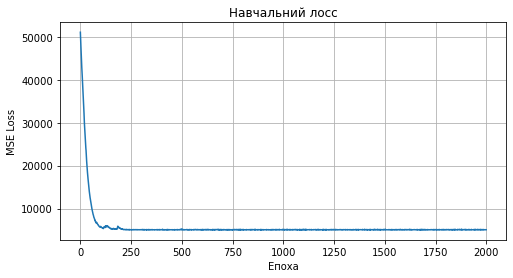

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.title("Навчальний лосс")
plt.xlabel("Епоха")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()


Модель навчилась, але не факт, що точно)

Доволі неочікувано, що середньоквадратичне відхилення тестового набору даних буде на порядок більшим за одиниці в нашому наборі даних. Середньоквадратичне відхилення 100 означає, що прогноз і фактичне значення будуть відрізнятися в середньому на 100 (тобто, 100 000 пасажирів у цьому наборі даних).



Щоб краще зрозуміти якість прогнозу, ви можете побудувати графік з кодом нижче (а ще нижче - описано, що відбувається в цьому коді, бо це теж корисно зрозуміти):

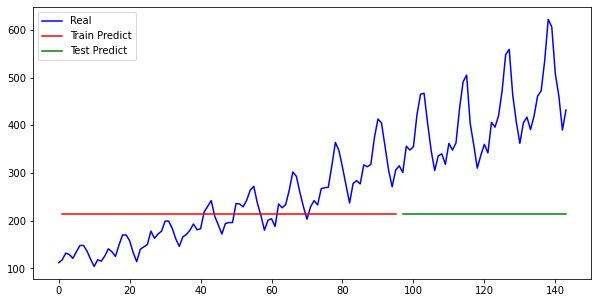

In [11]:
def plot_predicts():
    with torch.no_grad():
        # Train shift
        train_plot = np.ones_like(timeseries) * np.nan
        train_plot[lookback:train_size] = model(X_train)[:, -1].numpy()

        # Test shift
        test_plot = np.ones_like(timeseries) * np.nan
        test_plot[train_size+lookback:] = model(X_test)[:, -1].numpy()

    plt.figure(figsize=(10, 5))
    plt.plot(timeseries, label="Real", c='b')
    plt.plot(train_plot, label="Train Predict", c='r')
    plt.plot(test_plot, label="Test Predict", c='g')
    plt.legend()
    plt.show()

plot_predicts()


**Що відбувається в коді вище.** В цьому коді здійснюється процес прогнозування часових рядів за допомогою LSTM моделі, а також виведення графіку, який показує реальні значення, тренувальні та тестові прогнози. Ось що відбувається на кожному етапі:

1. **`torch.no_grad()`**: Цей контекстний менеджер вимикає обчислення градієнтів, що означає, що під час прогнозування не будуть зберігатися проміжні обчислення для зворотного проходу (backpropagation). Це підвищує ефективність під час прогнозування і зменшує використання пам'яті.

2. **Зсув прогнозів для тренувальних даних:**
   - Створюється масив `train_plot`, який має такий самий розмір, як і часовий ряд (`timeseries`), і заповнюється значеннями NaN (`np.nan`), щоб залишити місце для реальних значень.
   - Модель передбачає виходи для тренувальних даних `X_train`.
   - Використовується лише останнє передбачене значення для кожного входу LSTM (`y_pred[:, -1]`).
   - Прогнози зсуваються, починаючи з індексу `lookback` до кінця тренувальних даних (індекс `train_size`). Цей зсув потрібен, щоб зробити прогноз на основі попередніх даних і відобразити його на правильній частині графіку.

3. **Зсув прогнозів для тестових даних:**
   - Створюється масив `test_plot`, який також заповнюється NaN.
   - Прогнози для тестових даних додаються з індексу `train_size + lookback` до кінця реальних даних, щоб відобразити, де модель починає прогнозувати тестову вибірку.

4. **Побудова графіка:**
   - `plt.plot(timeseries, c='b')`: Виводить реальні значення часового ряду (синя лінія).
   - `plt.plot(train_plot, c='r')`: Виводить тренувальні прогнози (червона лінія).
   - `plt.plot(test_plot, c='g')`: Виводить тестові прогнози (зелена лінія).

**Чому це робиться:**
- Зсув прогнозів для тренувальних і тестових даних дозволяє візуально зрівняти, наскільки добре модель прогнозує як на тренувальній, так і на тестовій вибірках. Зазвичай, червона лінія (тренувальні прогнози) повинна точно відповідати синій лінії (реальні дані), а зелена лінія (тестові прогнози) дає змогу побачити, наскільки модель добре працює на нових даних, яких вона раніше не бачила.

**Завдання 8**. Навчіть модель з hidden_size=100 та порівняйте результати прогнозів з попередніми.

In [12]:
model2 = AirModel(hidden_size=100, num_layers=1)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
losses2 = []

for epoch in range(2000):
    model2.train()
    batch_losses = []

    for Xb, yb in train_loader:
        pred = model2(Xb)
        loss = loss_fn(pred, yb)

        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()

        batch_losses.append(loss.item())
    
    losses2.append(np.mean(batch_losses))

    if epoch % 100 == 0:
        model2.eval()
        with torch.no_grad():
            train_rmse = torch.sqrt(loss_fn(model2(X_train), y_train)).item()
            test_rmse = torch.sqrt(loss_fn(model2(X_test), y_test)).item()

        print(f"[HS=100] Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")


[HS=100] Epoch 0: train RMSE 221.2376, test RMSE 417.5640
[HS=100] Epoch 100: train RMSE 71.7210, test RMSE 223.5688
[HS=100] Epoch 200: train RMSE 71.2044, test RMSE 217.7274
[HS=100] Epoch 300: train RMSE 71.1492, test RMSE 215.2165
[HS=100] Epoch 400: train RMSE 71.1491, test RMSE 215.1885
[HS=100] Epoch 500: train RMSE 71.1491, test RMSE 215.0600
[HS=100] Epoch 600: train RMSE 71.1499, test RMSE 215.4138
[HS=100] Epoch 700: train RMSE 71.1492, test RMSE 215.2283
[HS=100] Epoch 800: train RMSE 71.1492, test RMSE 215.0020
[HS=100] Epoch 900: train RMSE 71.1491, test RMSE 215.0639
[HS=100] Epoch 1000: train RMSE 71.1491, test RMSE 215.0837
[HS=100] Epoch 1100: train RMSE 71.1497, test RMSE 214.8368
[HS=100] Epoch 1200: train RMSE 71.1491, test RMSE 215.0309
[HS=100] Epoch 1300: train RMSE 71.1498, test RMSE 215.4019
[HS=100] Epoch 1400: train RMSE 71.1491, test RMSE 215.1752
[HS=100] Epoch 1500: train RMSE 71.1492, test RMSE 214.9954
[HS=100] Epoch 1600: train RMSE 71.1499, test RMSE 

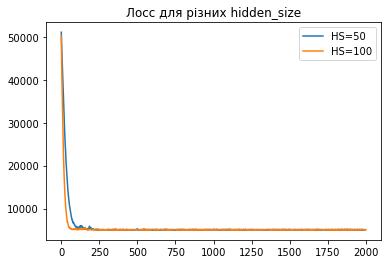

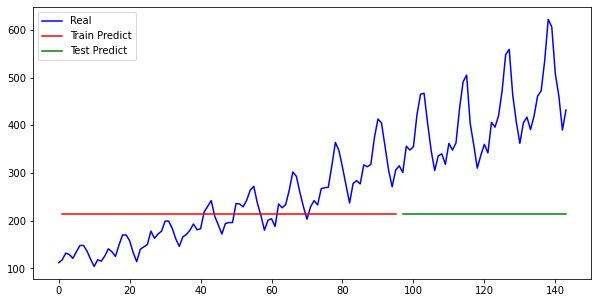

In [13]:
plt.plot(losses, label="HS=50")
plt.plot(losses2, label="HS=100")
plt.legend()
plt.title("Лосс для різних hidden_size")
plt.show()

model = model2
plot_predicts()


**Висновок:**

- Модель не змогла навчитися тренду і сезонності.
- Лосс дуже великий (приблизно 5000), що свідчить про слабку якість прогнозу.
- Прогнози постійні, як "середнє" значення (приблизно) і не повторюють сезонних коливань.

**Причини та як покращити:**

- Відсутність нормалізації: дані мають великий масштаб (100–600+). LSTM краще працює на масштабованих (нормалізованих) даних (наприклад, MinMaxScaler 0..1).

- Занадто малий lookback=1: 1 крок назад не дає достатньо інформації для прогнозування.

- Недостатня кількість прихованих шарів? Можливо, слід змінити параметри навчання (зменшити lr, збільшити кількість епох, ...).

X_train: torch.Size([89, 7, 1]) y_train: torch.Size([89, 1])
X_test: torch.Size([41, 7, 1]) y_test: torch.Size([41, 1])
Epoch 0: train RMSE 0.1327, test RMSE 0.4260
Epoch 100: train RMSE 0.0421, test RMSE 0.0929
Epoch 200: train RMSE 0.0383, test RMSE 0.0999
Epoch 300: train RMSE 0.0357, test RMSE 0.1154
Epoch 400: train RMSE 0.0352, test RMSE 0.1076
Epoch 500: train RMSE 0.0276, test RMSE 0.1261
Epoch 600: train RMSE 0.0231, test RMSE 0.1444
Epoch 700: train RMSE 0.0203, test RMSE 0.1449
Epoch 800: train RMSE 0.0174, test RMSE 0.1177
Epoch 900: train RMSE 0.0150, test RMSE 0.1211
Epoch 1000: train RMSE 0.0092, test RMSE 0.0942
Epoch 1100: train RMSE 0.0093, test RMSE 0.1051
Epoch 1200: train RMSE 0.0077, test RMSE 0.0939
Epoch 1300: train RMSE 0.0078, test RMSE 0.0900
Epoch 1400: train RMSE 0.0138, test RMSE 0.0845
Epoch 1500: train RMSE 0.0091, test RMSE 0.0793
Epoch 1600: train RMSE 0.0031, test RMSE 0.0814
Epoch 1700: train RMSE 0.0064, test RMSE 0.0776
Epoch 1800: train RMSE 0.004

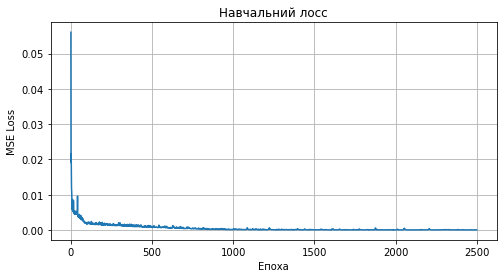

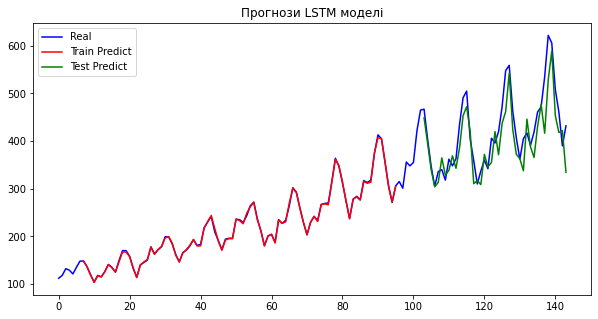

In [14]:
from sklearn.preprocessing import MinMaxScaler

# 1. Завантаження даних
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
passengers = np.array(df['Passengers'], dtype=np.float32)

# 2. Нормалізація MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
passengers_norm = scaler.fit_transform(passengers.reshape(-1, 1)).flatten()

# 3. Розбиття на train/val
train_size = int(len(passengers_norm) * 0.67)
train_data = passengers_norm[:train_size]
val_data = passengers_norm[train_size:]

# 4. Функція create_dataset з lookback
def create_dataset(dataset, lookback=1):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        X.append(dataset[i:i+lookback])
        y.append(dataset[i+lookback])
    X = torch.tensor(np.array(X), dtype=torch.float32).reshape(-1, lookback, 1)
    y = torch.tensor(np.array(y), dtype=torch.float32).reshape(-1, 1)
    return X, y

lookback = 7
X_train, y_train = create_dataset(train_data, lookback)
X_test, y_test = create_dataset(val_data, lookback)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

# 5. LSTM модель
class AirModel(nn.Module):
    def __init__(self, hidden_size=100, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1])
        return out

model = AirModel(hidden_size=120, num_layers=1)

# 6. DataLoader
batch_size = 8
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 7. Навчання
epochs = 2500
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []

for epoch in range(epochs):
    model.train()
    batch_losses = []

    for Xb, yb in train_loader:
        pred = model(Xb)
        loss = loss_fn(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())
    
    losses.append(np.mean(batch_losses))

    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            train_rmse = torch.sqrt(loss_fn(model(X_train), y_train)).item()
            test_rmse = torch.sqrt(loss_fn(model(X_test), y_test)).item()

        print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")

# 8. Графік лоссу
plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.title("Навчальний лосс")
plt.xlabel("Епоха")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

# 9. Функція для графіків прогнозів (зворотня денормалізація)
def plot_predicts():
    model.eval()
    with torch.no_grad():
        train_pred = model(X_train).numpy()
        test_pred = model(X_test).numpy()

    # Денормалізація
    train_pred_denorm = scaler.inverse_transform(train_pred)
    test_pred_denorm = scaler.inverse_transform(test_pred)
    actual_denorm = scaler.inverse_transform(passengers_norm.reshape(-1,1)).flatten()

    train_plot = np.ones_like(passengers) * np.nan
    train_plot[lookback:train_size] = train_pred_denorm.flatten()

    test_plot = np.ones_like(passengers) * np.nan
    test_plot[train_size+lookback:] = test_pred_denorm.flatten()

    plt.figure(figsize=(10,5))
    plt.plot(actual_denorm, label='Real', c='b')
    plt.plot(train_plot, label='Train Predict', c='r')
    plt.plot(test_plot, label='Test Predict', c='g')
    plt.legend()
    plt.title("Прогнози LSTM моделі")
    plt.show()

plot_predicts()


- Навчальний лосс швидко падає і досягає дуже малого значення (~0), що свідчить про успішне навчання моделі.

- Прогнози LSTM (червона — на тренувальних даних, зелена — на тестових) добре повторюють реальні дані (синя лінія), захоплюючи тренд і сезонність.

- Модель з нормалізацією і lookback=7 справді навчилась адекватно прогнозувати часовий ряд:

- Тренувальні прогнози майже збігаються з реальними.

- Тестові прогнози теж корелюють із реальними значеннями, хоч і з деяким відхиленням на останніх точках